# Deep Learning
## HW2 - Problem 1

Name: Sobhan Asasi

Student Number: 400206392

# Requirements

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from math import floor

%matplotlib inline

# Set random seeds
torch.manual_seed(30)
random.seed(30)
np.random.seed(30)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Part 1 : Load Dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

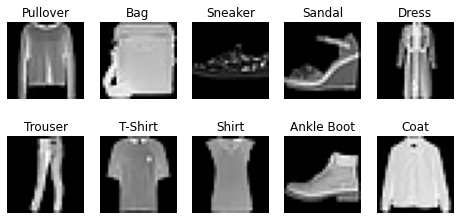

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

plotted_classes = []
i = 0
figure = plt.figure(figsize=(8, 8))

while len(plotted_classes) != 10:
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  if label not in plotted_classes:
    plotted_classes.append(label)
    i += 1
    figure.add_subplot(4, 5, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  
    
plt.show()

# Part 2 : Network Implementation

In [ ]:
W1 = torch.randn(256, 28*28, requires_grad=True)
b1 = torch.randn(256, 1, requires_grad=True)

W2 = torch.randn(128, 256, requires_grad=True)
b2 = torch.randn(128, 1, requires_grad=True)

W3 = torch.randn(64, 128, requires_grad=True)
b3 = torch.randn(64, 1, requires_grad=True)

W4 = torch.randn(10, 64, requires_grad=True)
b4 = torch.randn(10, 1, requires_grad=True)

In [ ]:
def ReLU(x):
  z = torch.zeros_like(x)
  y = torch.maximum(x, z)
  return y


def tanh(x):
  y = (torch.exp(x) - torch.exp(-1 * x)) / (torch.exp(x) + torch.exp(-1 * x))
  return y

def softmax(x):
  k , m, n = x.shape
  y =  torch.zeros_like(x)
  for i in range(k):
    v = x[i, :, :]
    y[i, :, :] = torch.exp(v) / torch.sum(torch.exp(v))
  return y

In [ ]:
def model(xb):
  global W1, b1, W2, b2, W3, b3, W4, b4
  y1 = torch.matmul(W1, xb) + b1
  y1 = tanh(y1)

  y2 = torch.matmul(W2, y1) + b2
  y2 = tanh(y2)

  y3 = torch.matmul(W3, y2) + b3
  y3 = tanh(y3)

  y4 = torch.matmul(W4, y3) + b4
  y4 = tanh(y4)

  yb = softmax(y4)
  return yb


# Part 3 - Train

In [ ]:
learning_rate = 1e-1
batch_size = 100
epochs = 100

In [ ]:
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

In [ ]:
train_size = int(len(training_data) * 0.8)
valid_size = len(training_data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(training_data,(train_size, valid_size))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
def BCE(y_hat, y):
  r =  (-1 / batch_size) * torch.sum(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
  return r

In [ ]:
def Train_Accuracy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = torch.reshape(X, (batch_size, 28*28, 1))
            y = torch.reshape(y, (batch_size, 10, 1))
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            for i in range(batch_size):
              v1 = pred[i, :, :]
              v2 = y[i, :, :]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
    train_loss /= num_batches
    correct /= size
    print(f"Train Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

In [ ]:
def Test_Accuracy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = torch.reshape(X, (batch_size, 28*28, 1))
            y = torch.reshape(y, (batch_size, 10, 1))
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            for i in range(batch_size):
              v1 = pred[i, :, :]
              v2 = y[i, :, :]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
    test_loss /= num_batches
    correct /= size
    print(f"Test Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
def train_loop(dataloader, model, loss_fn):
    global W1, b1, W2, b2, W3, b3, W4, b4
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = torch.reshape(X, (batch_size, 28*28, 1))
        y = torch.reshape(y, (batch_size, 10, 1))
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation

        loss.backward()
        # one step of SGD
        # clear old gradients from the last step
        with torch.no_grad():
          W1 -= learning_rate * W1.grad
          b1 -= learning_rate * b1.grad
          W2 -= learning_rate * W2.grad
          b2 -= learning_rate * b2.grad
          W3 -= learning_rate * W3.grad
          b3 -= learning_rate * b3.grad
          W4 -= learning_rate * W4.grad
          b4 -= learning_rate * b4.grad
          W1.grad.zero_()
          b1.grad.zero_()
          W2.grad.zero_()
          b2.grad.zero_()
          W3.grad.zero_()
          b3.grad.zero_()
          W4.grad.zero_()
          b4.grad.zero_()
          

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn=BCE)
    Train_Accuracy(train_dataloader, model, loss_fn=BCE)
    Test_Accuracy(valid_dataloader, model, loss_fn=BCE)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 33.1%, Avg loss: 2.632993 

Test Dataset: 
 Accuracy: 32.8%, Avg loss: 2.636034 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 45.0%, Avg loss: 2.401893 

Test Dataset: 
 Accuracy: 43.8%, Avg loss: 2.405298 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 54.7%, Avg loss: 2.245560 

Test Dataset: 
 Accuracy: 54.0%, Avg loss: 2.264329 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 58.6%, Avg loss: 2.188583 

Test Dataset: 
 Accuracy: 58.4%, Avg loss: 2.199533 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 62.4%, Avg loss: 2.129192 

Test Dataset: 
 Accuracy: 61.6%, Avg loss: 2.145719 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 64.9%, Avg loss: 2.078672 

Test Dataset: 
 Accuracy: 64.8%, Avg loss: 2.081764 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 66.6%, Avg loss: 2.032092 

Test Datase

# Part 4 - Test

In [ ]:
print('Model Accuracy on Test Data \n-------------------------------')
Test_Accuracy(test_dataloader, model, loss_fn=BCE)

Model Accuracy on Test Data 
-------------------------------
Test Dataset: 
 Accuracy: 80.8%, Avg loss: 1.735908 



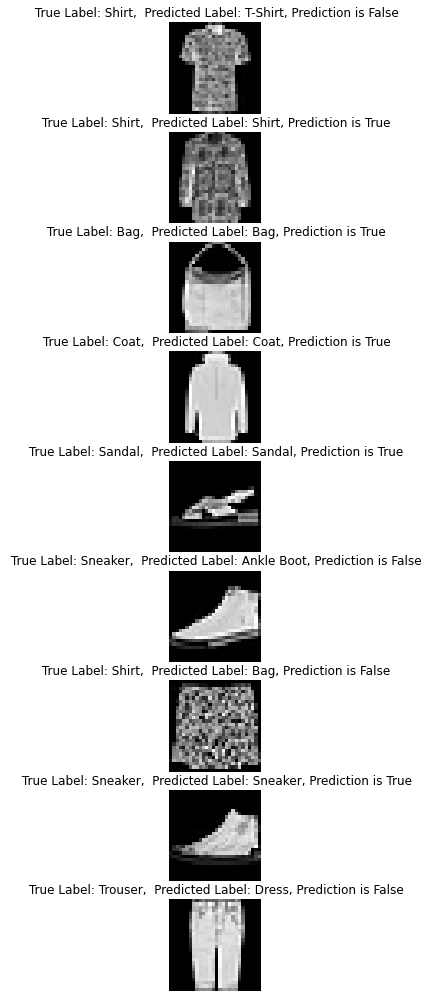

In [ ]:
figure = plt.figure(figsize=(40, 40))
i = 0
for j in range(9):
  i += 1
  sample_idx = torch.randint(len(test_data), size=(1,)).item()
  img, label = test_data[sample_idx]
  #
  with torch.no_grad():
    X = torch.reshape(img, (1, 28*28, 1))
    pred = model(X)
  figure.add_subplot(20, 1, i)
  label_true = labels_map[torch.argmax(label).item()]
  label_predicted = labels_map[torch.argmax(pred).item()]
  plt.title(f" True Label: {label_true},  Predicted Label: {label_predicted}, Prediction is {label_true == label_predicted}")
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray") 
  
plt.show()